In [10]:
# =========================
# CELL 1 — Config & Paths (judge-friendly + reproducible)
# - No hard-coded absolute paths
# - Works whether you run notebook from repo root or from notebooks/
# - DOES NOT copy data anywhere (judge-friendly)
# - Uses pathlib for cross-platform paths
# =========================

import os, re, json, math
from datetime import datetime, timezone
from typing import Dict, Any, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# Reproducibility seed
# -------------------------
SEED = int(os.environ.get("SEED", "42"))
np.random.seed(SEED)

# -------------------------
# Paths (robust for Jupyter)
# -------------------------
from pathlib import Path

def _find_repo_root(start: Path) -> Path:
    """
    Find project root by walking up until a folder containing 'notebooks' is found.
    Fallback: use current working dir.
    """
    start = start.resolve()
    for p in [start] + list(start.parents):
        if (p / "notebooks").exists():
            return p
    return start

# In Jupyter, __file__ may not exist. Use cwd.
CWD = Path.cwd().resolve()
REPO_ROOT = _find_repo_root(CWD)

# If notebook is in notebooks/, keep NOTEBOOKS_DIR = REPO_ROOT/notebooks
NOTEBOOKS_DIR = (REPO_ROOT / "notebooks").resolve()

# Data/outputs location:
# - Prefer notebooks/data if exists
# - Else fallback to repo_root/data
DATA_DIR = (NOTEBOOKS_DIR / "data") if (NOTEBOOKS_DIR / "data").exists() else (REPO_ROOT / "data")

# Outputs always under notebooks/outputs to match your current structure
OUT_DIR = NOTEBOOKS_DIR / "outputs"
OUT_02 = OUT_DIR / "02_eda"
OUT_03 = OUT_DIR / "03_features"
OUT_04 = OUT_DIR / "04_models"
OUT_04P = OUT_04 / "predictions"
OUT_05 = OUT_DIR / "05_scaling"

for p in [OUT_02, OUT_03, OUT_04, OUT_04P, OUT_05]:
    p.mkdir(parents=True, exist_ok=True)

# Provide string paths if later cells use os.path.join / strings
PROJECT_ROOT = str(NOTEBOOKS_DIR)  # keep compatible with later cells that expect PROJECT_ROOT as string

print("✅ Paths resolved:")
print(" - REPO_ROOT     :", REPO_ROOT)
print(" - NOTEBOOKS_DIR :", NOTEBOOKS_DIR)
print(" - DATA_DIR      :", DATA_DIR)
print(" - OUT_DIR       :", OUT_DIR)

# -------------------------
# Core helpers (keep as-is for other cells)
# -------------------------
def tag_minutes(tag: str) -> int:
    return {"1m": 1, "5m": 5, "15m": 15}[tag]

def steps_per_day(tag: str) -> int:
    return int(24 * 60 / tag_minutes(tag))

def steps_per_hour(tag: str) -> int:
    return int(60 / tag_minutes(tag))

def resolve_roll_windows(tag: str, roll_windows: List[str]) -> Dict[str, int]:
    sph = steps_per_hour(tag)
    spd = steps_per_day(tag)
    out = {}
    for w in roll_windows:
        if w == "1h":
            out[w] = 1 * sph
        elif w == "6h":
            out[w] = 6 * sph
        elif w == "1d":
            out[w] = 1 * spd
        else:
            raise ValueError(f"Unsupported roll window: {w}")
    return out

# -------------------------
# CFG (one source of truth)
# -------------------------
CFG: Dict[str, Any] = {
    # ===== Dataset =====
    # Prefer access_log.txt in DATA_DIR; judge just needs to put data in ./data or ./notebooks/data
    "RAW_LOG_PATH": str(DATA_DIR / "access_log.txt"),
    "TAGS": ["1m", "5m", "15m"],
    "TIME_COL_RAW": "timestamp",
    "TIME_COL_BUCKET": "bucket_start",

    # Storm gap (problem statement)
    "STORM_START": pd.Timestamp("1995-08-01 14:52:01"),
    "STORM_END":   pd.Timestamp("1995-08-03 04:36:13"),

    # ===== Feature engineering =====
    "LAG_DAYS": [1,2,3,4,5,6,7],
    "ROLL_WINDOWS": ["1h","6h","1d"],
    "ROLL_USE_STD": True,
    "USE_CYCLIC": True,
    "HORIZON_STEPS": 1,
    "KEEP_RAW_EXTRA": [
        "unique_hosts","err_4xx","err_5xx","error_rate",
        "is_missing_bucket","is_gap_storm","is_gap_unknown"
    ],
    "REQUIRE_COLS": ["bucket_start","hits","bytes_sum","is_gap"],

    # ===== Modeling =====
    "TARGETS": ["hits", "bytes_sum"],
    "XGB_PARAMS": dict(
        booster="gbtree",
        n_estimators=5000,
        early_stopping_rounds=50,
        objective="reg:squarederror",
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=SEED,
    ),
    "CV_SPLITS": 5,
    "CV_TEST_DAYS": 2,
    "CV_GAP_STEPS": 1,

    # ==========================================================
    # AUTOSCALING / SIMULATION CONFIG (Window-aware + Metric-aware)
    # ==========================================================
    "SCALING": {
        "min_instances": 2,
        "max_instances": 50,
        "cost_per_instance_per_hour": 0.05,
        "window_minutes": {"1m": 1, "5m": 5, "15m": 15},
        "safety_buffer_by_metric": {"hits": 0.3, "bytes_sum": 0.3},
        "capacity_per_instance": {
            ("hits","1m"): 20, ("hits","5m"): 100, ("hits","15m"): 350,
            ("bytes_sum","1m"): 350_000, ("bytes_sum","5m"): 1_200_000, ("bytes_sum","15m"): 3_500_000,
        },
        "max_step_change_by_window": {"1m": 6, "5m": 10, "15m": 15},
        "hysteresis_by_window": {
            "1m": {"high": 2, "low": 6, "in_margin": 0.18},
            "5m": {"high": 1, "low": 4, "in_margin": 0.15},
            "15m":{"high": 1, "low": 2, "in_margin": 0.12},
        },
        "predictive_deadband_by_window": {"1m": 0.5, "5m": 0.5, "15m": 0.5},
        "cooldown_minutes": {"base": 8, "spike": 15},
        "provisioning_by_window": {
            "1m": {"warmup_windows": 1, "min_uptime_windows": 6},
            "5m": {"warmup_windows": 1, "min_uptime_windows": 4},
            "15m":{"warmup_windows": 0, "min_uptime_windows": 2},
        },
        "reactive": {
            "enabled": True,
            "overload_scale_out_immediate": True,
            "rescue_extra_instances": 3,
            "queue_low_fraction": 0.05,
            "queue_high_multiplier": 4.0,
        },
        "slo": {
            "base_latency_ms": 80.0,
            "alpha_latency_per_unit_queue": 0.15,
            "p95_latency_target_ms": 300.0,
        },
        "anomaly": {
            "enabled": True,
            "method": "mad",
            "lookback_hours": 2,
            "mad_k": 6.0,
            "min_points": 10,
            "max_flag_rate": 0.30,
        },
        "ddos_mode": {
            "enabled": True,
            "force_scale_out_step_by_window": {"1m": 6, "5m": 10, "15m": 12},
            "max_instances_during_ddos": 50,
        },
    }
}

print("✅ Cell 1 done — CFG ready (CFG['SCALING'] exists)")


✅ Paths resolved:
 - REPO_ROOT     : C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS
 - NOTEBOOKS_DIR : C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS\notebooks
 - DATA_DIR      : C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS\notebooks\data
 - OUT_DIR       : C:\Users\PC\OneDrive - National Economics University\Máy tính\SC\AUTOSCALING-ANALYSIS\notebooks\outputs
✅ Cell 1 done — CFG ready (CFG['SCALING'] exists)


C:\Users\PC\AppData\Local\Temp\ipykernel_15100\4209554516.py:220: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat([ev_static, ev_pred], ignore_index=True).to_csv(os.path.join(OUT_05,"scaling_events_all.csv"), index=False)


  metric window policy_mode  estimated_total_cost  total_server_hours  \
0   hits     5m      static               53.0000             1060.00   
1   hits     5m  predictive               34.5625              691.25   

   avg_instances  peak_instances  sla_violation_rate  slo_violation_rate  \
0       5.000000               5            0.020440                 0.0   
1       3.260613              15            0.077437                 0.0   

   total_under_provision  max_under_provision  num_scale_events  \
0                 2425.0                155.0                 0   
1                 9570.0                199.0               154   

   events_per_hour  num_points  
0         0.000000        2544  
1         0.726415        2544  


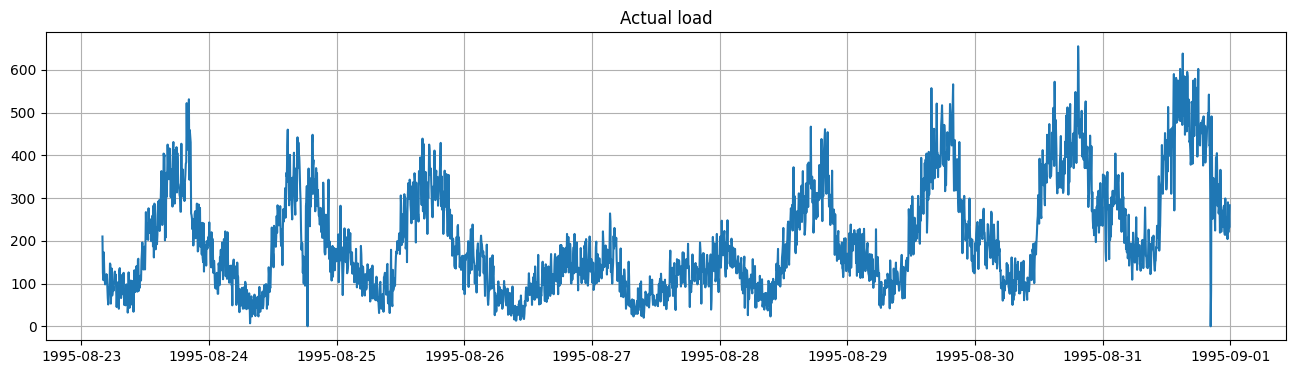

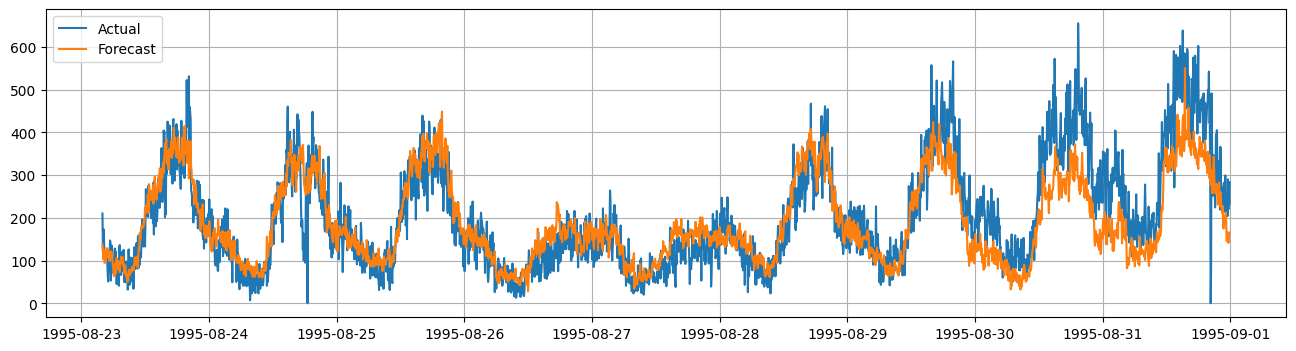

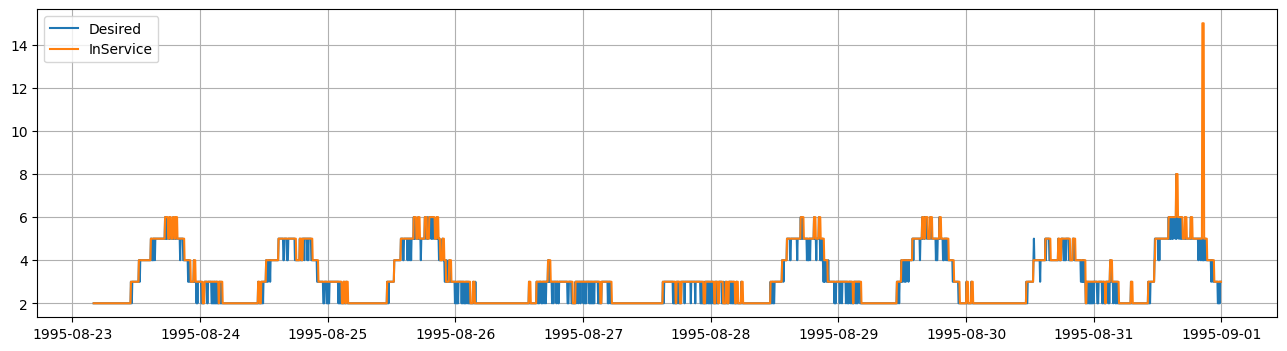

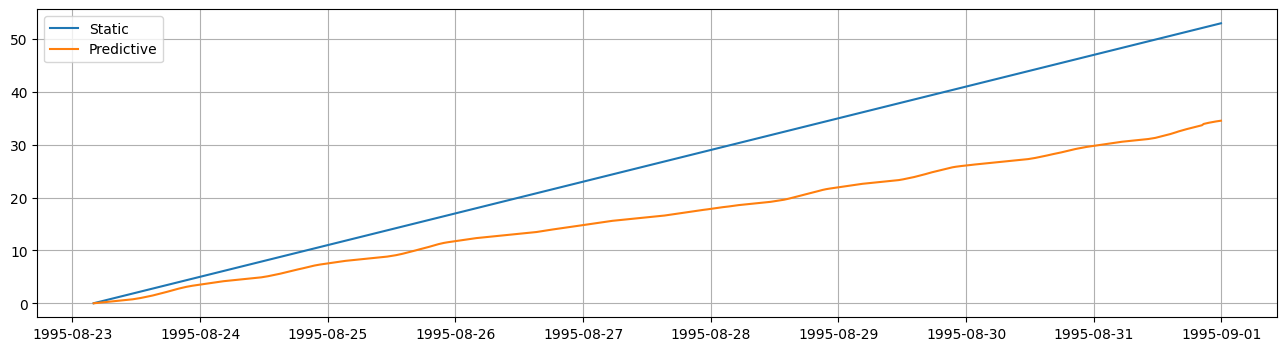

In [11]:
# =========================
# 05_scaling_policy_simu.ipynb — Setup (judge-friendly)
# =========================
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Reproducible
SEED = int(os.environ.get("SEED", "42"))
np.random.seed(SEED)

# Detect base dir (prefer notebooks/)
cwd = Path.cwd()
if cwd.name.lower() == "notebooks":
    BASE_DIR = cwd
elif (cwd / "notebooks").exists():
    BASE_DIR = cwd / "notebooks"
else:
    BASE_DIR = cwd

# Paths
OUT_04P = Path(os.environ.get("OUT_04P", str(BASE_DIR / "outputs" / "04_models" / "predictions")))
OUT_05  = Path(os.environ.get("OUT_05",  str(BASE_DIR / "outputs" / "05_scaling")))
OUT_05.mkdir(parents=True, exist_ok=True)

# CFG/SCALING must exist (if user runs this notebook standalone)
if "CFG" not in globals():
    raise RuntimeError(
        "CFG is not defined. Please run CELL 1 (config) first "
        "or define CFG['SCALING'] before running this notebook."
    )

SC = CFG["SCALING"]

def win_minutes(window): return int(SC["window_minutes"][window])
def win_hours(window): return win_minutes(window)/60.0
def clamp_instances(x): return max(int(SC["min_instances"]), min(int(SC["max_instances"]), int(x)))
def cap(metric, window): return float(SC["capacity_per_instance"][(metric, window)])
def buffer(metric): return float(SC["safety_buffer_by_metric"].get(metric,0.2))
def step_limit(window): return int(SC["max_step_change_by_window"].get(window,10))

def required_instances(demand, metric, window):
    d=max(0.0,float(demand)); c=max(cap(metric,window),1e-9)
    need=(d/c)*(1.0+buffer(metric))
    return clamp_instances(int(math.ceil(need)))

def _apply_step_towards(inst, target, max_step):
    delta=int(target)-int(inst)
    if delta==0: return int(inst)
    step=int(np.sign(delta))*min(abs(delta), int(max_step))
    return clamp_instances(int(inst)+step)

def mad_anomaly_flags(series, window_pts, k, min_points=10):
    x=series.astype(float).copy()
    mp=max(1, min(int(window_pts), max(int(min_points), int(window_pts)//2)))
    med=x.rolling(int(window_pts), min_periods=mp).median()
    mad=(x-med).abs().rolling(int(window_pts), min_periods=mp).median()
    score=(x-med).abs()/mad.replace(0,np.nan)
    is_spike=(score>k).fillna(False).astype(int)
    return score.fillna(0.0), is_spike

def ddos_flag(is_spike, consec):
    run=is_spike.rolling(consec, min_periods=consec).sum()
    return (run>=consec).fillna(False).astype(int)

def simulate_queue_latency(sim_df, lat_cfg):
    df=sim_df.sort_values("timestamp").reset_index(drop=True).copy()
    q=0.0
    ql=[]; util=[]; p95=[]; slo=[]
    for _,r in df.iterrows():
        load=float(r["y_true"]); cap_total=float(r["capacity_total"])
        _served=min(load+q, cap_total)
        q=max(0.0,(load+q)-cap_total)
        q=max(0.0,q*(1.0-float(lat_cfg["queue_decay"])))
        u=0.0 if cap_total<=1e-9 else min(2.0, load/cap_total)
        p=float(lat_cfg["base_ms"])+float(lat_cfg["alpha_ms_per_queue_unit"])*q
        v=bool(p>float(lat_cfg["p95_target_ms"]))
        ql.append(q); util.append(u); p95.append(p); slo.append(v)
    df["queue_len"]=ql; df["utilization"]=util; df["p95_latency_ms"]=p95; df["slo_violation"]=pd.Series(slo).astype(bool)
    return df

def summarize(sim_df, ev_df):
    metric=str(sim_df["metric"].iloc[0]); window=str(sim_df["window"].iloc[0]); policy=str(sim_df["policy_mode"].iloc[0])
    n=int(len(sim_df))
    total_cost=float(sim_df["cost_step"].sum())
    total_server_hours=float(sim_df["server_hours_step"].sum())
    avg_instances=float(sim_df["instances"].mean())
    peak_instances=int(sim_df["instances"].max())
    sla_violation_rate=float(sim_df["sla_violation"].mean())
    slo_violation_rate=float(sim_df["slo_violation"].mean()) if "slo_violation" in sim_df.columns else np.nan
    total_under=float(sim_df["under_provision"].sum())
    max_under=float(sim_df["under_provision"].max())
    num_scale_events=int(len(ev_df)) if ev_df is not None else 0
    sim_hours=(n*win_minutes(window))/60.0
    events_per_hour=float(num_scale_events/max(sim_hours,1e-9))
    return dict(metric=metric, window=window, policy_mode=policy,
                estimated_total_cost=total_cost, total_server_hours=total_server_hours,
                avg_instances=avg_instances, peak_instances=peak_instances,
                sla_violation_rate=sla_violation_rate, slo_violation_rate=float(slo_violation_rate),
                total_under_provision=total_under, max_under_provision=max_under,
                num_scale_events=num_scale_events, events_per_hour=events_per_hour, num_points=n)

# Choose case
metric="hits"; window="5m"; model_tag="xgb"
fp = OUT_04P / f"pred_{metric}_{window}_{model_tag}.csv"
if not fp.exists():
    raise FileNotFoundError(
        f"Missing prediction file: {fp}\n"
        f"Hint: run 04_modeling_forecast.ipynb first to generate outputs/04_models/predictions."
    )
dfp = pd.read_csv(fp)
dfp["timestamp"] = pd.to_datetime(dfp["bucket_start"], errors="coerce")
# nếu vẫn lỡ dính tz-aware thì convert về naive
if getattr(dfp["timestamp"].dt, "tz", None) is not None:
    dfp["timestamp"] = dfp["timestamp"].dt.tz_convert(None)

dfp=dfp.dropna(subset=["timestamp"]).copy()
df_case=pd.DataFrame({"timestamp":dfp["timestamp"],
                      "y_true":pd.to_numeric(dfp[metric],errors="coerce").fillna(0.0),
                      "y_pred":pd.to_numeric(dfp["pred"],errors="coerce").fillna(0.0)}).sort_values("timestamp").reset_index(drop=True)

TEST_START=pd.Timestamp("1995-08-23 00:00:00"); TEST_END=pd.Timestamp("1995-09-01 00:00:00")
df_case=df_case[(df_case["timestamp"]>=TEST_START)&(df_case["timestamp"]<TEST_END)].copy().reset_index(drop=True)

# Static baseline from "train" slice (no leakage)
TRAIN_END=pd.Timestamp("1995-08-23 00:00:00")
df_train=df_case[df_case["timestamp"]<TRAIN_END].copy()
if df_train.empty:
    df_train=df_case.iloc[:int(len(df_case)*0.7)].copy()

static_req_train=df_train["y_true"].apply(lambda x: required_instances(x, metric, window))
static_n=clamp_instances(int(np.nanpercentile(static_req_train.values,95)))

def simulate_static(df_case, static_n):
    wh=win_hours(window); unit_cost=float(SC["cost_per_instance_per_hour"]); inst=static_n
    rows=[]
    for _,r in df_case.iterrows():
        y_true=float(r["y_true"]); y_pred=float(r["y_pred"])
        cap_total=inst*cap(metric,window)
        headroom=cap_total-y_true
        under=max(0.0,-headroom); over=max(0.0,headroom)
        cost_step=inst*wh*unit_cost
        rows.append(dict(timestamp=r["timestamp"], metric=metric, window=window, policy_mode="static",
                         y_true=y_true, y_pred=y_pred, required_instances=required_instances(y_pred,metric,window),
                         instances=inst, effective_instances=inst, capacity_total=cap_total, headroom=headroom,
                         under_provision=under, over_provision=over, sla_violation=bool(under>0.0),
                         cost_step=cost_step, server_hours_step=inst*wh, cost_rate_per_hour=inst*unit_cost))
    return pd.DataFrame(rows), pd.DataFrame(columns=["timestamp","metric","window","policy_mode","action","from_instances","to_instances","delta","reason"])

def simulate_predictive(df_case):
    wh=win_hours(window); unit_cost=float(SC["cost_per_instance_per_hour"])
    h=SC["hysteresis_by_window"][window]
    k_high=int(h["high"]); k_low=int(h["low"]); in_margin=float(h["in_margin"])
    cooldown_w=int(math.ceil(float(SC["cooldown_minutes"]["base"])/win_minutes(window)))
    prov=SC["provisioning_by_window"][window]
    warmup_w=int(prov["warmup_windows"]); min_uptime_w=int(prov["min_uptime_windows"])
    inst=int(SC["min_instances"])
    above=below=0; cooldown_left=warmup_left=uptime_guard=0
    rows=[]; events=[]
    # anomaly/ddos
    an=SC.get("anomaly",{}); dd=SC.get("ddos_mode",{})
    enable_anom=bool(an.get("enabled",True))
    if enable_anom:
        lookback_pts=max(5,int((float(an.get("lookback_hours",2))*60)/win_minutes(window)))
        an_score,is_spike=mad_anomaly_flags(df_case["y_true"], lookback_pts, float(an.get("mad_k",6.0)), int(an.get("min_points",10)))
        is_ddos=ddos_flag(is_spike,3) if bool(dd.get("enabled",True)) else pd.Series(np.zeros(len(df_case),dtype=int))
    else:
        an_score=pd.Series(np.zeros(len(df_case))); is_spike=pd.Series(np.zeros(len(df_case),dtype=int)); is_ddos=pd.Series(np.zeros(len(df_case),dtype=int))

    for i,r in df_case.iterrows():
        req=required_instances(r["y_pred"], metric, window)
        above=(above+1) if (req>inst) else 0
        below=(below+1) if (inst>req*(1.0+in_margin)) else 0
        cooldown_left=max(0,cooldown_left-1); warmup_left=max(0,warmup_left-1); uptime_guard=max(0,uptime_guard-1)
        new_inst=inst; action="hold"; reason="hold"
        ddos_on=bool(dd.get("enabled",True) and int(is_ddos.iloc[i])==1)
        if ddos_on:
            force=int(dd.get("force_scale_out_step_by_window",{}).get(window, step_limit(window)))
            new_inst=min(int(dd.get("max_instances_during_ddos", SC["max_instances"])), inst+max(1,force))
            action="scale_out"; reason="ddos_mode(force_step)"
        elif cooldown_left==0:
            if above>=k_high:
                new_inst=_apply_step_towards(inst, req, step_limit(window)); action="scale_out"; reason=f"req>inst for {k_high}"
            elif below>=k_low and uptime_guard==0:
                new_inst=_apply_step_towards(inst, req, step_limit(window)); action="scale_in"; reason=f"inst>req*(1+margin) for {k_low}"
        if new_inst!=inst:
            events.append(dict(timestamp=r["timestamp"], metric=metric, window=window, policy_mode="predictive",
                               action=action, from_instances=inst, to_instances=new_inst, delta=new_inst-inst, reason=reason))
            inst=new_inst; cooldown_left=cooldown_w; warmup_left=max(warmup_left,warmup_w); uptime_guard=max(uptime_guard,min_uptime_w)
        effective=max(0, inst-warmup_left)
        cap_total=effective*cap(metric,window)
        headroom=cap_total-float(r["y_true"])
        under=max(0.0,-headroom); over=max(0.0,headroom)
        cost_step=inst*wh*unit_cost
        rows.append(dict(timestamp=r["timestamp"], metric=metric, window=window, policy_mode="predictive",
                         y_true=float(r["y_true"]), y_pred=float(r["y_pred"]), required_instances=req,
                         instances=inst, effective_instances=effective, warmup_left_windows=warmup_left,
                         blocked_by_cooldown=bool(cooldown_left>0), capacity_total=cap_total, headroom=headroom,
                         under_provision=under, over_provision=over, sla_violation=bool(under>0.0),
                         cost_step=cost_step, server_hours_step=inst*wh, cost_rate_per_hour=inst*unit_cost,
                         anomaly_score=float(an_score.iloc[i]), is_spike=int(is_spike.iloc[i]), is_ddos=int(is_ddos.iloc[i])))
    return pd.DataFrame(rows), pd.DataFrame(events)

sim_static, ev_static = simulate_static(df_case, static_n)
sim_pred, ev_pred = simulate_predictive(df_case)

LAT_CFG={"base_ms":float(SC.get("slo",{}).get("base_latency_ms",80.0)),
         "alpha_ms_per_queue_unit":float(SC.get("slo",{}).get("alpha_latency_per_unit_queue",0.15)),
         "p95_target_ms":float(SC.get("slo",{}).get("p95_latency_target_ms",300.0)),
         "queue_decay":0.02}

sim_static=simulate_queue_latency(sim_static, LAT_CFG)
sim_pred=simulate_queue_latency(sim_pred, LAT_CFG)

summary_df=pd.DataFrame([summarize(sim_static, ev_static), summarize(sim_pred, ev_pred)])
summary_df.to_csv(os.path.join(OUT_05,"summary_cost_perf.csv"), index=False)
pd.concat([sim_static, sim_pred], ignore_index=True).to_csv(os.path.join(OUT_05,"sim_timeseries_all.csv"), index=False)
pd.concat([ev_static, ev_pred], ignore_index=True).to_csv(os.path.join(OUT_05,"scaling_events_all.csv"), index=False)

print(summary_df)

# Plots
ts=sim_pred["timestamp"]
plt.figure(figsize=(16,4)); plt.plot(ts, sim_pred["y_true"]); plt.title("Actual load"); plt.grid(True); plt.show()
plt.figure(figsize=(16,4)); plt.plot(ts, sim_pred["y_true"], label="Actual"); plt.plot(ts, sim_pred["y_pred"], label="Forecast"); plt.legend(); plt.grid(True); plt.show()
plt.figure(figsize=(16,4)); plt.plot(ts, sim_pred["required_instances"], label="Desired"); plt.plot(ts, sim_pred["instances"], label="InService"); plt.legend(); plt.grid(True); plt.show()
plt.figure(figsize=(16,4)); plt.plot(sim_static["timestamp"], sim_static["cost_step"].cumsum(), label="Static"); plt.plot(sim_pred["timestamp"], sim_pred["cost_step"].cumsum(), label="Predictive"); plt.legend(); plt.grid(True); plt.show()
